In [2]:
#reloads imported library automatically
from IPython.lib.deepreload import reload
%load_ext autoreload
%autoreload 2

In [3]:
import numpy as np
#from numpy.random import choice
import matplotlib.pyplot as plt
from stl import mesh
from mpl_toolkits import mplot3d

import sys 
if ".." not in sys.path: sys.path.insert(0,"..") # add parent folder path
import LittleFunction #so we can still access this file

### Getting basic Cherenkov light source for chroma
Mostly using Soud's code at https://github.com/soudk/phys512/blob/master/project_cherenkov/NumbaCherenkov.ipynb

In [95]:
#Soud's numbers

#In eV
energies = np.array([0.602, 0.689, 1.03,  1.926, 2.583, 2.845, 2.857, 3.124,3.457, 3.643, 3.812, 4.086, 4.511, 4.953, 5.474, 6.262, 7.000, 8.300, 10.00, 12.60])
#Refractive index of water from Segelstein, David J. The complex refractive index of water. Diss. University of Missouri--Kansas City, 1981.
n = np.array([1.303, 1.3120,   1.3239,   1.3313, 1.3358, 1.3376, 1.3376, 1.3392, 1.3423, 1.3442, 1.3460, 1.3486, 1.3540, 1.3619, 1.3723, 1.3960, 1.3960, 1.3960,1.3960, 1.3960])

wavelengths = 1239.8/energies
freq = 3e17/wavelengths

#Only take the ~near visible range (where photomultiplier tubes are sensitive). 
#This is the tail of the Cherenkov emission spectrum.
cut = [3,7]
# cut = [0,len(n)]

freq = freq[cut[0]:cut[1]]
wavelengths=wavelengths[cut[0]:cut[1]]
energies=energies[cut[0]:cut[1]]
n=n[cut[0]:cut[1]]

In [96]:
# Values from nEXO_offline
eV = 1
H2OEnergy_od = np.array([2.07*eV, 2.09*eV, 2.12*eV, 2.20*eV, 2.31*eV,
       2.41*eV, 2.48*eV, 2.55*eV, 2.71*eV, 2.83*eV ,
       2.96*eV, 3.05*eV, 3.13*eV, 3.25*eV, 3.32*eV,
       3.45*eV, 3.57*eV, 3.69*eV, 3.85*eV, 3.99*eV,
       4.26*eV, 4.99*eV, 5.29*eV]) #eV

H2ORefractiveIndex_od = np.array([1.332     , 1.33233458, 1.33275974, 1.333     , 1.33337057,
       1.33440426, 1.33497163, 1.33553901, 1.33667376, 1.33746809,
       1.33824548, 1.33866779, 1.33926229, 1.34044132, 1.34115378,
       1.3422317 , 1.34324954, 1.34459331, 1.34635211, 1.34761808,
       1.35056125, 1.36267944, 1.36844391])

wavelengths_od = 1239.8/H2OEnergy_od
freq_od = 3e17/wavelengths_od

print("Soud's limits [nm]:", np.min(wavelengths), np.max(wavelengths))
print("nEXO's limits: [nm]", np.min(wavelengths_od), np.max(wavelengths_od))

Soud's limits [nm]: 433.9516975848792 643.717549325026
nEXO's limits: [nm] 234.36672967863893 598.9371980676328


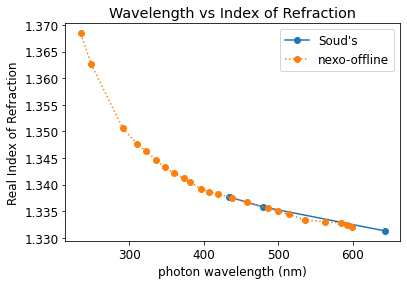

In [97]:
#radians, approx Cherenkov angle in optical (~0.5 degree precision)
thetaRel = 0.733 

plt.plot(wavelengths, n, marker='o', label="Soud's")
# plt.plot(energies, n, marker='o', label="Soud's")

plt.plot(wavelengths_od, H2ORefractiveIndex_od, marker='o', ls=':', label="nexo-offline")

plt.xlabel('photon wavelength (nm)')
plt.ylabel('Real Index of Refraction')
plt.title('Wavelength vs Index of Refraction')

plt.legend()
plt.show()

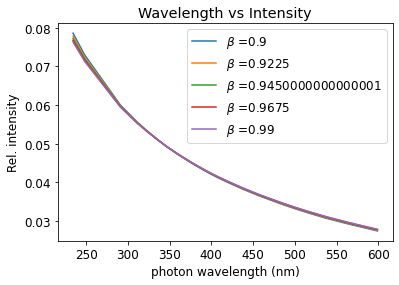

In [124]:
#I think mu(w) is constant in this range... So we can ignore the normalization then normalize later
def IntensityWavelength(freq, beta, n):
    E_loss = 1.0/(4*np.pi) * freq*(1.0 - 1.0/(beta**2.0 * n**2.0))
    E_loss_rel = E_loss/np.abs(E_loss.sum())
    return E_loss, E_loss_rel

b = np.linspace(0.9, 0.99, 5)

for beta in b:
    E_loss, E_loss_rel = IntensityWavelength(freq_od, beta, H2ORefractiveIndex_od)
    plt.plot(wavelengths_od, E_loss_rel, '-',label=r'$\beta$ ='+str(beta) )
    
plt.xlabel('photon wavelength (nm)')
plt.ylabel('Rel. intensity')
plt.title('Wavelength vs Intensity')

plt.legend()
plt.show()

# Sampling wavelengths

390.89490793533764


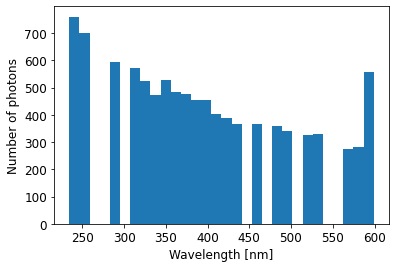

In [127]:
# sample wavelengths from above
E_loss, E_loss_rel = IntensityWavelength(freq_od, .99, H2ORefractiveIndex_od)

photonWavelen = np.random.choice(wavelengths_od, p=E_loss_rel, size=10000)

# print(photonWavelen)

print(np.average(photonWavelen))
plt.hist(photonWavelen, bins=30)
plt.xlabel("Wavelength [nm]")
plt.ylabel("Number of photons")
plt.show() 

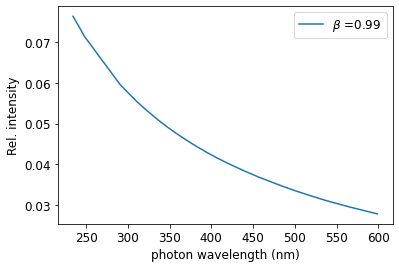

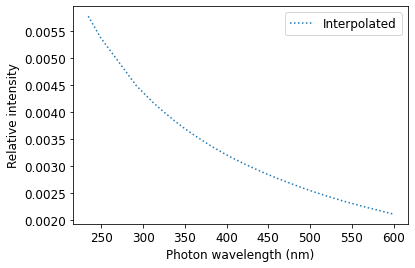

In [130]:
def IntensityWavelength(freq, beta, n):
    E_loss = 1.0/(4*np.pi) * freq*(1.0 - 1.0/(beta**2.0 * n**2.0))
    E_loss_rel = E_loss/np.abs(E_loss.sum())
    return E_loss, E_loss_rel

beta = .99

#actual data
E_loss, E_loss_rel = IntensityWavelength(freq_od, beta, H2ORefractiveIndex_od)
plt.plot(wavelengths_od, E_loss_rel, '-',label=r'$\beta$ ='+str(beta) )
plt.xlabel('photon wavelength (nm)')
plt.ylabel('Rel. intensity')
plt.legend()
plt.show()

#interpolated
wavelength_intep = np.linspace(np.min(wavelengths_od), np.max(wavelengths_od), 300)
#need to flip data arrays as np.interp needs increasing x values
E_loss_rel_intep = np.interp(wavelength_intep, wavelengths_od[::-1], E_loss_rel[::-1])

E_loss_rel_intep = E_loss_rel_intep/np.sum(E_loss_rel_intep)


plt.plot(wavelength_intep, E_loss_rel_intep, ':', label='Interpolated' )

plt.xlabel('Photon wavelength (nm)')
plt.ylabel('Relative intensity')
plt.legend()
plt.show()

386.4440401609793


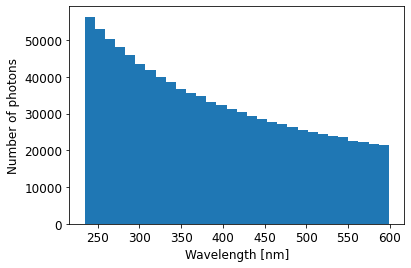

In [131]:
photonWavelen = np.random.choice(wavelength_intep, p=E_loss_rel_intep, size=1000000)

# print(photonWavelen)

print(np.average(photonWavelen))
plt.hist(photonWavelen, bins=30)
plt.xlabel("Wavelength [nm]")
plt.ylabel("Number of photons")
plt.show() 

average: 425.5523210702339


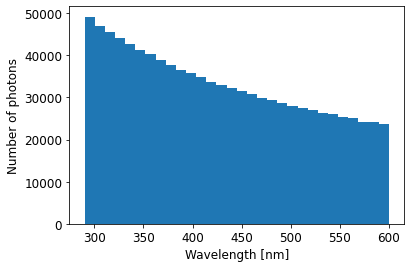

In [132]:
NumPhotons = 1000000
MuonEnergy = 10 #GeV

randomWave = LittleFunction.getCherenkovWavelengthSample(NumPhotons, MuonEnergy, Interp=True)
print("average:", np.average(randomWave))
plt.hist(randomWave, bins=30)
plt.xlabel("Wavelength [nm]")
plt.ylabel("Number of photons")
plt.show() 

### Trying to smear the wavelength distribution with the PMT's QE

In [136]:
wavelength_intep = np.linspace(290, 600, 300)
#need to flip data arrays as np.interp needs increasing x values
E_loss_rel_intep = np.interp(wavelength_intep, wavelengths_od[::-1], E_loss_rel[::-1])

E_loss_rel_intep = E_loss_rel_intep/np.sum(E_loss_rel_intep)

# print(sum(E_loss_rel_intep))

300


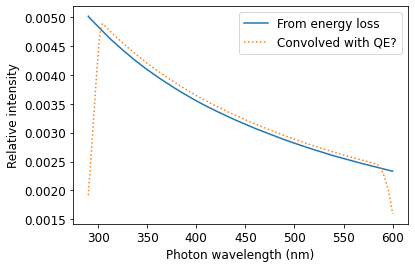

In [147]:
# wavelength_intep, E_loss_rel_intep
# BialkaliQE_energies, BialkaliQE

plt.show()

Wave_convolve = np.convolve(E_loss_rel_intep, BialkaliQE, mode='same')

Wave_convolve = Wave_convolve/np.sum(Wave_convolve) #need to renormalize
print(len(Wave_convolve))

plt.plot(wavelength_intep, E_loss_rel_intep, label='From energy loss' )
# plt.plot(EToWave(BialkaliQE_energies), BialkaliQE,  label='QE' )

plt.plot(wavelength_intep, Wave_convolve, ':', label='Convolved with QE?' )


plt.xlabel('Photon wavelength (nm)')
plt.ylabel('Relative intensity')
plt.legend()
plt.show()

### Looking at angle as a function of energy

In [37]:
def GetBeta(energy):
    # E = gamma*(mc^2)
    gamma = energy/0.10566 #where does this come from? is it mc^2 in GeV ? Yup it's the muon mass
    return np.sqrt(1.0 - 1.0/(gamma**2.0))

def getEnergy(beta):
    energy = np.sqrt( 1/(1 - beta**2 )) * 0.10566
    return energy

def getAngle(beta, n):
    return np.arccos(1/(beta*n)) #in rad?

def getBetaFromAngle(theta, n):
    beta = 1/(np.cos(theta)*n)
    energy = np.sqrt( 1/(1 - beta**2 )) * 0.10566
    return beta, energy

#light if beta > 1/n
print("I've been using theta=", 0.733, 'rad or ', np.degrees(0.733))

print("Beta:", GetBeta(10)) #1GeV to beta
print("Theta: ", getAngle(GetBeta(1), 1.33), "rad")  #1GeV to beta

print("Beta, energy [GeV]", getBetaFromAngle(2.7, 1.33))

print("must have Beta >", 1/1.33, getEnergy(1/1.33), "GeV")

I've been using theta= 0.733 rad or  41.99780638308934
Beta: 0.9999441782639669
Theta:  0.713444443877857 rad
Beta, energy [GeV] (-0.8316589620498793, 0.1902800682086686)
must have Beta > 0.7518796992481203 0.16026080388090544 GeV


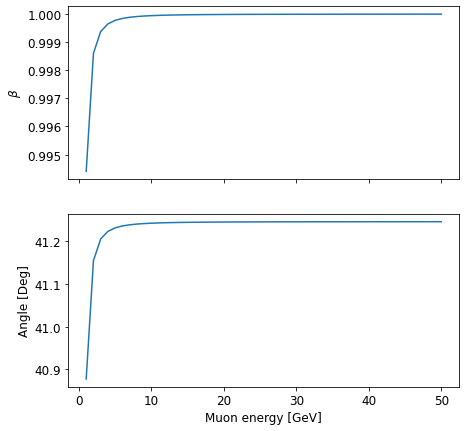

<ipython-input-37-8ce0ea679058>:11: RuntimeWarning: invalid value encountered in arccos
  return np.arccos(1/(beta*n)) #in rad?


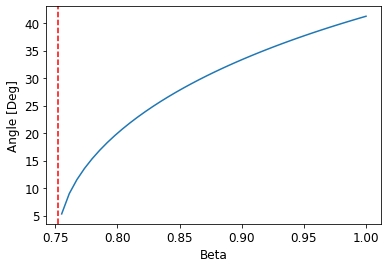

In [38]:
E = np.linspace(1, 50) #GeV

f, axs = plt.subplots(nrows=2, ncols=1, sharex=True, squeeze=True, figsize=(7,7))

axs[0].plot(E, GetBeta(E))
# plt.axhline(1/1.33, ls='--', color='r')
# axs[0].set_xlabel('Muon energy [GeV]')
axs[0].set_ylabel('$\\beta$')

# axs[1].plot(E, getAngle(GetBeta(E), 1.33))
# axs[1].set_ylabel('Angle [Rad]')

axs[1].plot(E, np.degrees(getAngle(GetBeta(E), 1.33)))
axs[1].set_xlabel('Muon energy [GeV]')

axs[1].set_ylabel('Angle [Deg]')

plt.show()

b = np.linspace(.7, 1)
plt.plot(b, np.degrees(getAngle(b, 1.33)))
plt.axvline(1/1.33, ls='--', color='r')
plt.xlabel('Beta')

plt.ylabel('Angle [Deg]')

plt.show()

## Trying to look at number of photons / length

In [67]:
alpha = 1/137. #fine structure constant 
n = 1.33

def num(lambda_1, lambda_2, beta):
#     print(beta*n) #must be > 1
    N = 2*np.pi*alpha*(1/lambda_1 - 1/lambda_2 )*(1-1/((beta*n)**2))
    
    return N

def num_in(lambda_1, beta):
    N = 2*np.pi*alpha*(1-1/(beta**2 * n**2))*(1/lambda_1**2)
    
    return N

In [68]:
NumberOfPhotons = num(300, 500, 0.99) * 1e6 #number of photons for per mm 
print("Number of photons for per mm :", NumberOfPhotons, "with wavelengths in 300-500 nm.")

lambda_min = np.min(wavelengths_od)
lambda_max = np.max(wavelengths_od)

NumberOfPhotons = num(lambda_min, lambda_max, 0.99) * 1e6 #number of photons for per mm 
print("Number of photons for per mm :", NumberOfPhotons, "with wavelengths in {:.2f} - {:.2f} nm.".format(lambda_min, lambda_max))

Number of photons for per mm : 25.87868645456868 with wavelengths in 300-500 nm.
Number of photons for per mm : 50.40895933842826 with wavelengths in 234.37 - 598.94 nm.


In [91]:
lambda_min = 290
lambda_max = 600

muonE = np.linspace(0.16, 10, 100)
# get number of photons for per mm 
NumberOfPhotons = num(lambda_min, lambda_max, GetBeta(muonE)) * 1e6

#look how the max number of photons (so for beta=1) changes wrt lower wavelength limit used
lambda_minArr = np.linspace(230, 370, 100) #nm
NumberOfPhotons_max = num(lambda_minArr, lambda_max, 1) * 1e6

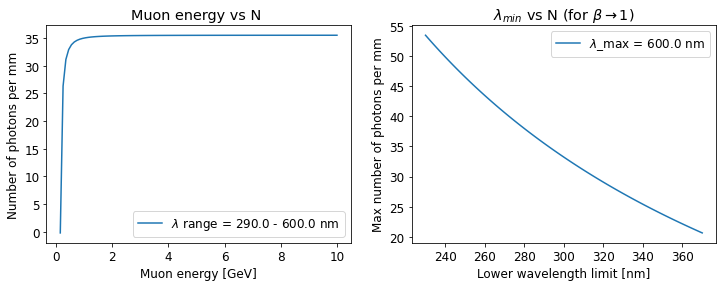

In [94]:
plt.rcParams.update({'font.size': 12})
f, axs = plt.subplots(nrows=1, ncols=2, figsize=(12,4))

axs[0].plot(muonE, NumberOfPhotons, label="$\lambda$ range = {:.1f} - {:.1f} nm".format(lambda_min, lambda_max))
axs[0].set_title("Muon energy vs N ")

axs[0].set_xlabel('Muon energy [GeV]')
axs[0].set_ylabel('Number of photons per mm')

axs[1].plot(lambda_minArr, NumberOfPhotons_max, label="$\lambda$_max = {:.1f} nm".format(lambda_max))

axs[1].set_title("$\lambda_{min}$ vs N (for $\\beta \\rightarrow 1$)")
axs[1].set_xlabel('Lower wavelength limit [nm]')
axs[1].set_ylabel('Max number of photons per mm')

# for wl in wavelengths_od[15:]:
#     axs[1].axvline(wl, ls=':', color='g')

axs[0].legend()
axs[1].legend()

plt.show()

In [72]:
num(290, 600, GetBeta(1.)) * 1e6


34.995654344953266

### Look at QE

In [18]:
#from nexo-offline, in but used in implemented in post-sim Analysis
#https://github.com/nEXO-collaboration/nexo-offline/blob/beed13d4801f142f4a0c8fdcae6c5609b01ae831/Simulation/DetSim/nEXOSim/src/nEXOMaterials.cc#L1044
BialkaliQE_energies = np.array([1.55,1.8,1.9,2,2.05,2.16,2.19,2.23,2.27,2.32,2.36,2.41,2.46,2.5,2.56,2.61,2.67,2.72,2.79,2.85,
                       2.92,2.99,3.06,3.14,3.22,3.31,3.4,3.49,3.59,3.7,3.81,3.94,4.07,4.1,4.4,5,6.2,10.33,15.5])
BialkaliQE = np.array([0.0001,0.002,0.005,0.01,0.017,0.03,0.04,0.05,0.06,0.07,0.08,0.09,0.1,0.11,0.13,0.15,0.16,0.18,0.19,0.2,
              0.21,0.22,0.22,0.23,0.24,0.24,0.24,0.23,0.22,0.21,0.17,0.14,0.09,0.035,0.005,0.001,0.0001,0.0,0.0])

EToWave = lambda E: 1239.8/E
WaveToE = lambda W: 1239.8/W

<ipython-input-18-426097d7c0fe>:8: RuntimeWarning: divide by zero encountered in true_divide
  EToWave = lambda E: 1239.8/E


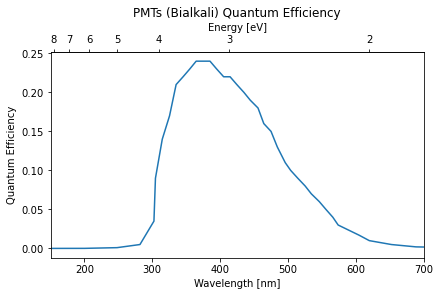

In [24]:
fig, ax = plt.subplots(constrained_layout=True)

ax.plot(EToWave(BialkaliQE_energies), BialkaliQE)
ax.set_xlabel('Wavelength [nm]')
ax.set_ylabel('Quantum Efficiency')
ax.set_title("PMTs (Bialkali) Quantum Efficiency")

ax.set_xlim(150, 700)

secax = ax.secondary_xaxis('top', functions=(WaveToE, EToWave))
secax.set_xlabel('Energy [eV]')

plt.show()

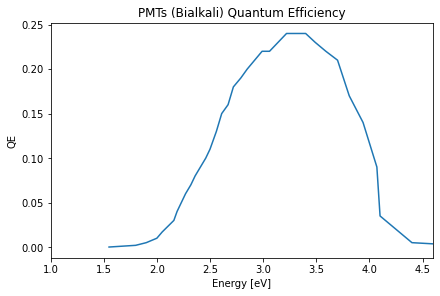

In [20]:
fig, ax = plt.subplots(constrained_layout=True)

ax.plot(BialkaliQE_energies, BialkaliQE)
ax.set_xlabel('Energy [eV]')
ax.set_ylabel('QE')
ax.set_title("PMTs (Bialkali) Quantum Efficiency")
ax.set_xlim(1, 4.6)

plt.show()

In [21]:
print(wavelengths_od[15:])

[359.36231884 347.28291317 335.98915989 322.02597403 310.72681704
 291.03286385 248.45691383 234.36672968]


In [22]:
lambda_min = np.min([i for i in wavelengths_od if i >260])

# i for i in a if i > 0
lambda_max = np.max(wavelengths_od)

NumberOfPhotons = num(lambda_min, lambda_max, 0.99) * 1e6 #number of photons for per mm 
print("Number of photons for per mm :", NumberOfPhotons, "with wavelengths in {:.2f} - {:.2f} nm.".format(lambda_min, lambda_max))

muonE = np.linspace(0.16, 10, 100)
# get number of photons for per mm 
NumberOfPhotons = num(lambda_min, lambda_max, GetBeta(muonE)) * 1e6

Number of photons for per mm : 34.28435433265773 with wavelengths in 291.03 - 598.94 nm.


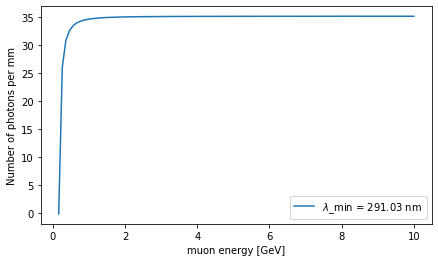

In [23]:
f, axs = plt.subplots(nrows=1, ncols=1, figsize=(7,4))

axs.plot(muonE, NumberOfPhotons, label="$\lambda$_min = {:.2f} nm".format(lambda_min))

axs.set_xlabel('muon energy [GeV]')
axs.set_ylabel('Number of photons per mm')

axs.legend()
plt.show()